In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

In [40]:
device = 'cpu'
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.config.use_cache = True
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [52]:
chunks = [
    "[According to recent studies, regular exercise improves mental health by reducing symptoms of anxiety.], ",
    "[Research indicates that outdoor activities, contribute to mental well-being by reducing stress.], ",
    "[Experts suggest aerobic and strength training boost cognitive functions and enhance neuroplasticity.], ",
]

prompt = "My question: How does regular exercise contribute to mental health, cognitive function, stress and wellbeing?"

for chunk in chunks:
    input_ids = tokenizer.encode(chunk, return_tensors='pt')
    print(len(input_ids[0]))

input_ids = tokenizer.encode(prompt, return_tensors='pt')
print(len(input_ids[0]))



19
19
19
19


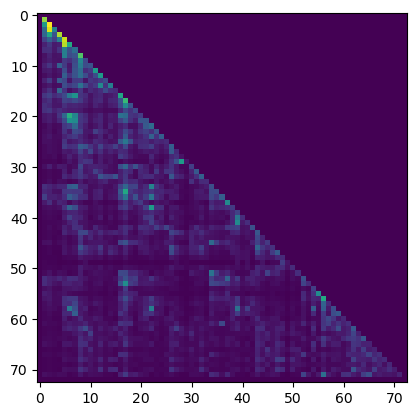

In [59]:
text = chunks[0]+chunks[1]+chunks[2]+prompt
input_ids = tokenizer.encode(text, return_tensors='pt')
input_ids = input_ids.to(model.device)
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

attentions = outputs.attentions
attentions = attentions[-1].squeeze(0).mean(dim=0) # Last layer attentions
attentions[-1, :] = 0.0
attentions[:, 0] = 0.0

plt.imshow(attentions)


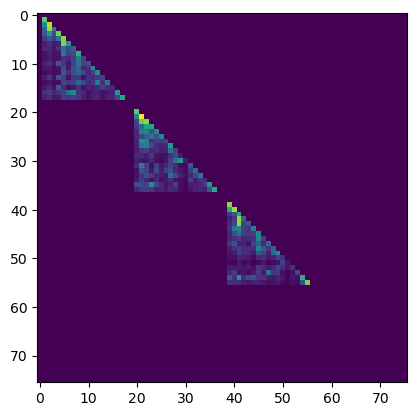

In [58]:
r = torch.zeros((19*4, 19*4))

for i, chunk in enumerate(chunks):
    input_ids = tokenizer.encode(chunk, return_tensors='pt')
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, output_attentions=True)

    attentions = outputs.attentions
    attentions = attentions[-1].squeeze(0).mean(dim=0) # Last layer attentions
    attentions[-1, :] = 0.0
    attentions[:, 0] = 0.0
 
    j = i * 19
    r[j:j+19, j:j+19] = attentions

plt.imshow(r)


In [60]:
from sentence_transformers import SentenceTransformer
emb_model = SentenceTransformer('all-MiniLM-L6-v2') 

def insert(text):
    """
    Virtually inserts a record into the vector database. Each record is an embedding, text and KV-cache
    """
    input_ids = tokenizer.encode(text, return_tensors='pt')
    input_ids = input_ids.to(model.device)
    with torch.no_grad():
        outputs = model(input_ids, use_cache=True)
    
    kv_cache = outputs.past_key_values

    embedding = emb_model.encode(text)
    
    return embedding, text, kv_cache

In [69]:
vectordb = []

# Populate the VectorDB
for chunk in chunks:
    emb, text, kv_cache = insert(chunk)
    vectordb.append({"embedding": emb, "text": text, "kv_cache": kv_cache})
    

In [76]:
len(vectordb)

3

In [78]:
def align_and_combine_kv_caches(kv_caches_list):
    """
    Aligns and combines KV caches from multiple chunks.
    """
    num_layers = len(kv_caches_list[0])  # Number of transformer layers
    combined_kv_cache = []

    for layer_idx in range(num_layers):
        # Collect keys and values from all chunks for this layer
        keys = []
        values = []
        for kv_cache in kv_caches_list:
            keys.append(kv_cache[layer_idx][0])   # Key tensor
            values.append(kv_cache[layer_idx][1])  # Value tensor
        
        # Concatenate along the sequence length dimension (-2)
        combined_key = torch.cat(keys, dim=-2)
        combined_value = torch.cat(values, dim=-2)
        
        combined_kv_cache.append((combined_key, combined_value))
    
    return tuple(combined_kv_cache)


In [80]:
# Align and combine KV caches
retrieved_kv_caches = [chunk["kv_cache"] for chunk in vectordb]
combined_kv_cache = align_and_combine_kv_caches(retrieved_kv_caches)

In [81]:
def generate_response(prompt, combined_kv_cache):
    """
    Generates a response using the combined KV cache.
    """
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
    
    # Generate output using the combined KV cache
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_length=50,
            past_key_values=combined_kv_cache,
            do_sample=False
        )
    
    # Decode the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Generate the response
response = generate_response(prompt, combined_kv_cache)
print("Response:", response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Response: My question: How does regular exercise contribute to mental health, cognitive function, stress and wellbeing?



The authors of the study also found that the effects of exercise on the brain are not limited to the brain. ?"

"
